# Hidden Markov Model (HMM) — Implementation, Training, and Decoding

This notebook implements a simple discrete Hidden Markov Model (HMM) from scratch using an object-oriented design. It demonstrates:

- Forward and backward algorithms (with scaling for numeric stability)
- Baum–Welch (EM) algorithm to estimate HMM parameters from observed sequences
- Viterbi algorithm for decoding the most likely hidden state sequence
- Synthetic data generation from a known HMM for testing and evaluation
- Evaluation of decoding accuracy (when true hidden states are available)

The implementation is intentionally straightforward and well-commented to be educational and reusable. For continuous emissions or large state spaces, consider numeric/stochastic improvements and library implementations (e.g., hmmlearn, pomegranate). 

In [1]:
# Imports and simple helpers
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from sklearn.metrics import accuracy_score, confusion_matrix

np.random.seed(42)


def plot_state_sequence(obs: List[int], states: List[int], title: str = '') -> None:
    """Plot observations and decoded states on a horizontal timeline for a single sequence."""
    T = len(obs)
    fig, axes = plt.subplots(2, 1, figsize=(12, 3), sharex=True)

    axes[0].scatter(range(T), obs, c='black')
    axes[0].set_ylabel('Observation')
    axes[0].set_yticks(sorted(set(obs)))

    axes[1].plot(range(T), states, drawstyle='steps-mid')
    axes[1].set_ylabel('State')
    axes[1].set_xlabel('Time')

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


In [3]:
class DiscreteHMM:
    """A simple discrete Hidden Markov Model (HMM).

    Attributes:
        n_states: number of hidden states
        n_obs: number of distinct observation symbols (0..n_obs-1)
        start_prob: initial state distribution (shape n_states)
        trans_prob: state transition matrix (n_states x n_states)
        emit_prob: emission matrix (n_states x n_obs)
    """

    def __init__(self, n_states: int, n_obs: int, random_state: int = None):
        self.n_states = n_states
        self.n_obs = n_obs
        self.random_state = random_state
        if random_state is not None:
            np.random.seed(random_state)

        # Parameters will be initialized later or by caller
        self.start_prob = np.full(n_states, 1.0 / n_states)
        self.trans_prob = np.full((n_states, n_states), 1.0 / n_states)
        self.emit_prob = np.full((n_states, n_obs), 1.0 / n_obs)

    def _normalize_rowwise(self, M: np.ndarray) -> np.ndarray:
        """Normalize rows of matrix so they sum to 1."""
        M = np.array(M, dtype=float)
        row_sums = M.sum(axis=1, keepdims=True)
        # avoid division by zero
        row_sums[row_sums == 0] = 1.0
        return M / row_sums

    def randomize_parameters(self):
        """Initialize start/trans/emit probabilities randomly (stochastic matrices)."""
        self.start_prob = np.random.rand(self.n_states)
        self.start_prob /= self.start_prob.sum()

        self.trans_prob = np.random.rand(self.n_states, self.n_states)
        self.trans_prob = self._normalize_rowwise(self.trans_prob)

        self.emit_prob = np.random.rand(self.n_states, self.n_obs)
        self.emit_prob = self._normalize_rowwise(self.emit_prob)

    def _forward(self, obs_seq: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Forward algorithm with scaling for numeric stability.

        Returns:
            alpha (T x n_states): scaled forward probabilities
            scales (T,): scaling factors used at each time
        """
        T = len(obs_seq)
        alpha = np.zeros((T, self.n_states))
        scales = np.zeros(T)

        # Initialization
        alpha[0] = self.start_prob * self.emit_prob[:, obs_seq[0]]
        scales[0] = alpha[0].sum()
        if scales[0] == 0:
            scales[0] = 1e-12
        alpha[0] /= scales[0]

        # Induction
        for t in range(1, T):
            obs = obs_seq[t]
            # compute unscaled alpha
            alpha[t] = (alpha[t-1] @ self.trans_prob) * self.emit_prob[:, obs]
            scales[t] = alpha[t].sum()
            if scales[t] == 0:
                scales[t] = 1e-12
            alpha[t] /= scales[t]

        return alpha, scales

    def _backward(self, obs_seq: np.ndarray, scales: np.ndarray) -> np.ndarray:
        """Backward algorithm using scaling factors from forward pass.

        Returns:
            beta (T x n_states): scaled backward probabilities
        """
        T = len(obs_seq)
        beta = np.zeros((T, self.n_states))

        # Initialization: beta_T-1 = 1 / scale_T-1
        beta[-1] = 1.0 / scales[-1]

        for t in reversed(range(T - 1)):
            obs_next = obs_seq[t + 1]
            # beta[t] = (trans_prob * emit_prob[:, obs_next]) @ beta[t+1]
            beta[t] = (self.trans_prob * self.emit_prob[:, obs_next]) @ beta[t + 1]
            beta[t] /= scales[t]

        return beta

    def _compute_xi_gamma(self, obs_seq: np.ndarray, alpha: np.ndarray, beta: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Compute expected transitions (xi) and expected state occupancy (gamma) for a single sequence.

        Returns:
            xi: (T-1, n_states, n_states) expected transitions
            gamma: (T, n_states) expected state occupancies
        """
        T = len(obs_seq)
        xi = np.zeros((T - 1, self.n_states, self.n_states))
        gamma = np.zeros((T, self.n_states))

        for t in range(T - 1):
            obs_next = obs_seq[t + 1]
            # numerator: alpha[t,i] * a_ij * b_j(obs_{t+1}) * beta[t+1,j]
            numer = np.outer(alpha[t], beta[t + 1] * self.emit_prob[:, obs_next]) * self.trans_prob
            denom = numer.sum()
            if denom == 0:
                denom = 1e-12
            xi[t] = numer / denom
            gamma[t] = xi[t].sum(axis=1)

        gamma[-1] = alpha[-1] * beta[-1]
        # normalize gamma rows (should already sum to 1 due to scaling, but keep for safety)
        gamma_sum = gamma.sum(axis=1, keepdims=True)
        gamma_sum[gamma_sum == 0] = 1e-12
        gamma /= gamma_sum

        return xi, gamma

    def baum_welch(self, sequences: List[np.ndarray], max_iters: int = 50, tol: float = 1e-4, verbose: bool = False) -> None:
        """Train HMM parameters from observed sequences using Baum-Welch (EM).

        Params:
            sequences: list of 1D numpy arrays of observation symbols (integers 0..n_obs-1)
            max_iters: maximum EM iterations
            tol: relative improvement threshold on log-likelihood for convergence
            verbose: print progress
        """
        # Random init if uniform
        self.randomize_parameters()

        prev_loglik = None
        for iteration in range(max_iters):
            # Accumulators for re-estimation
            A_num = np.zeros((self.n_states, self.n_states))
            A_den = np.zeros(self.n_states)
            B_num = np.zeros((self.n_states, self.n_obs))
            pi_accum = np.zeros(self.n_states)
            total_loglik = 0.0

            for obs_seq in sequences:
                alpha, scales = self._forward(obs_seq)
                beta = self._backward(obs_seq, scales)
                xi, gamma = self._compute_xi_gamma(obs_seq, alpha, beta)

                # accumulate start probabilities
                pi_accum += gamma[0]

                # accumulate transitions
                A_num += xi.sum(axis=0)
                A_den += gamma[:-1].sum(axis=0)

                # accumulate emissions
                T = len(obs_seq)
                for t in range(T):
                    B_num[:, obs_seq[t]] += gamma[t]
                B_den = gamma.sum(axis=0)

                # log-likelihood for the sequence: sum log(scales)
                seq_loglik = np.sum(np.log(scales + 1e-12))
                total_loglik += seq_loglik

            # Re-estimate pi, A, B
            self.start_prob = pi_accum / pi_accum.sum()

            # Avoid division by zero
            A_den_safe = A_den.copy()
            A_den_safe[A_den_safe == 0] = 1e-12
            self.trans_prob = A_num / A_den_safe[:, None]

            B_den_safe = B_num.sum(axis=1)
            B_den_safe[B_den_safe == 0] = 1e-12
            self.emit_prob = B_num / B_den_safe[:, None]

            if verbose:
                print(f"Iter {iteration+1} | LogLik: {total_loglik:.4f}")

            # Check convergence
            if prev_loglik is not None:
                if abs((total_loglik - prev_loglik)) < tol * max(1.0, abs(prev_loglik)):
                    if verbose:
                        print("Converged")
                    break
            prev_loglik = total_loglik

    def viterbi(self, obs_seq: np.ndarray) -> List[int]:
        """Viterbi algorithm to find the most likely hidden state path for a single observation sequence."""
        T = len(obs_seq)
        delta = np.zeros((T, self.n_states))  # max prob of any path ending in state i at time t
        psi = np.zeros((T, self.n_states), dtype=int)  # argmax pointers

        # Initialization
        delta[0] = np.log(self.start_prob + 1e-12) + np.log(self.emit_prob[:, obs_seq[0]] + 1e-12)

        for t in range(1, T):
            obs = obs_seq[t]
            for j in range(self.n_states):
                prob = delta[t - 1] + np.log(self.trans_prob[:, j] + 1e-12)
                psi[t, j] = np.argmax(prob)
                delta[t, j] = prob[psi[t, j]] + np.log(self.emit_prob[j, obs] + 1e-12)

        # backtrack
        states = np.zeros(T, dtype=int)
        states[-1] = np.argmax(delta[-1])
        for t in reversed(range(1, T)):
            states[t - 1] = psi[t, states[t]]

        return states.tolist()

    def score(self, obs_seq: np.ndarray) -> float:
        """Return log-likelihood of an observation sequence under the current model (via forward scaling factors)."""
        _, scales = self._forward(obs_seq)
        return np.sum(np.log(scales + 1e-12))

    def predict(self, sequences: List[np.ndarray]) -> List[List[int]]:
        """Decode each sequence using Viterbi and return list of state sequences."""
        return [self.viterbi(seq) for seq in sequences]


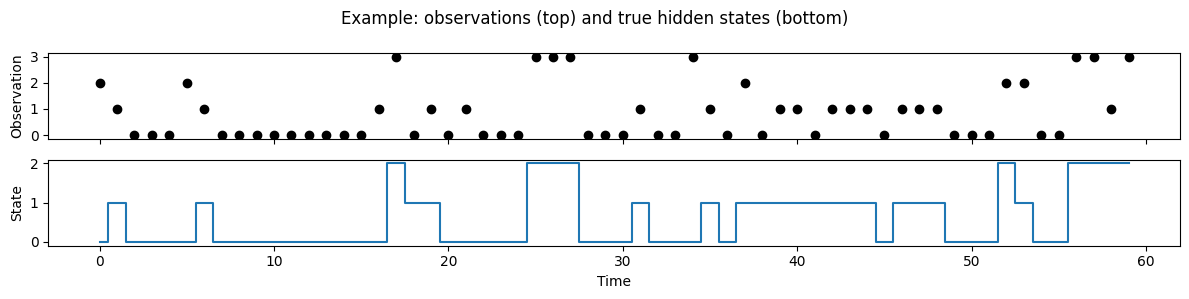

Iter 1 | LogLik: -7368.0006
Iter 2 | LogLik: -5902.1152
Iter 2 | LogLik: -5902.1152
Iter 3 | LogLik: -5898.7145
Iter 3 | LogLik: -5898.7145
Iter 4 | LogLik: -5895.1042
Iter 5 | LogLik: -5891.0310
Iter 6 | LogLik: -5886.2136
Iter 4 | LogLik: -5895.1042
Iter 5 | LogLik: -5891.0310
Iter 6 | LogLik: -5886.2136
Iter 7 | LogLik: -5880.3239
Iter 8 | LogLik: -5872.9820
Iter 7 | LogLik: -5880.3239
Iter 8 | LogLik: -5872.9820
Iter 9 | LogLik: -5863.7740
Iter 10 | LogLik: -5852.3109
Iter 11 | LogLik: -5838.3391
Iter 9 | LogLik: -5863.7740
Iter 10 | LogLik: -5852.3109
Iter 11 | LogLik: -5838.3391
Iter 12 | LogLik: -5821.8900
Iter 13 | LogLik: -5803.4071
Iter 14 | LogLik: -5783.7700
Iter 15 | LogLik: -5764.1919
Iter 12 | LogLik: -5821.8900
Iter 13 | LogLik: -5803.4071
Iter 14 | LogLik: -5783.7700
Iter 15 | LogLik: -5764.1919
Iter 16 | LogLik: -5746.0302
Iter 17 | LogLik: -5730.4974
Iter 18 | LogLik: -5718.2770
Iter 16 | LogLik: -5746.0302
Iter 17 | LogLik: -5730.4974
Iter 18 | LogLik: -5718.2770
It

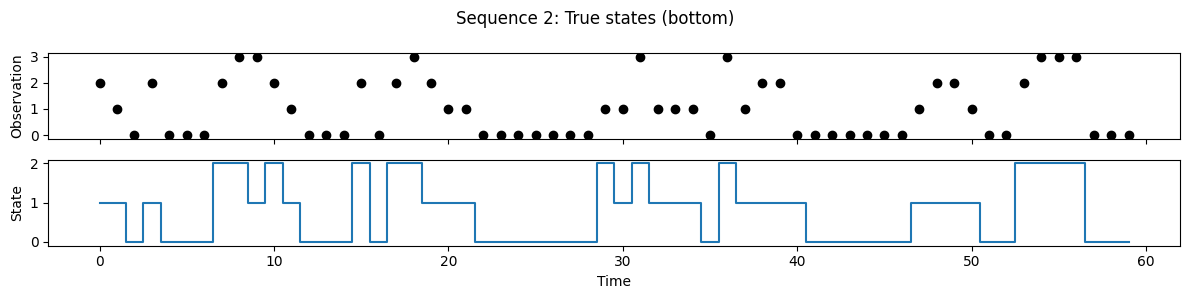

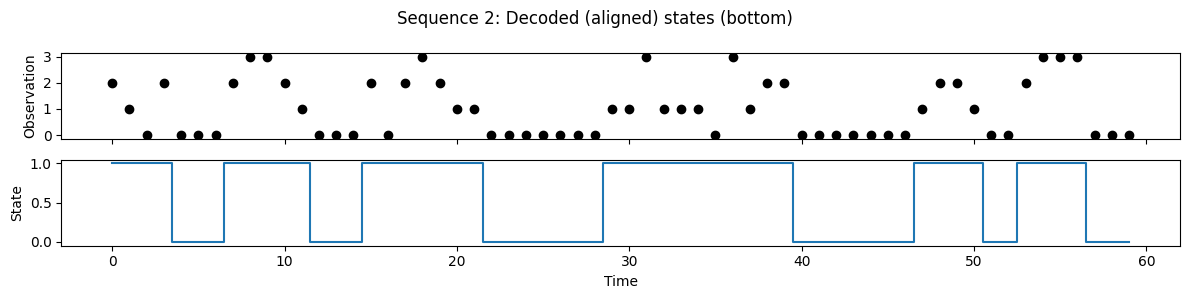

In [4]:
# 4) Simulate data from a known HMM and train the model

def generate_hmm_sequences(start_prob, trans_prob, emit_prob, n_sequences=50, seq_length=50):
    """Generate observation sequences and hidden state sequences from given HMM params."""
    sequences = []
    states = []
    for _ in range(n_sequences):
        s = np.zeros(seq_length, dtype=int)
        o = np.zeros(seq_length, dtype=int)
        # initial state
        s[0] = np.random.choice(len(start_prob), p=start_prob)
        o[0] = np.random.choice(emit_prob.shape[1], p=emit_prob[s[0]])
        for t in range(1, seq_length):
            s[t] = np.random.choice(len(start_prob), p=trans_prob[s[t-1]])
            o[t] = np.random.choice(emit_prob.shape[1], p=emit_prob[s[t]])
        sequences.append(o)
        states.append(s)
    return sequences, states

# Define a toy HMM (3 states, 4 observation symbols)
true_start = np.array([0.6, 0.3, 0.1])
true_trans = np.array([[0.7, 0.2, 0.1],
                       [0.3, 0.6, 0.1],
                       [0.2, 0.3, 0.5]])
true_emit = np.array([[0.9, 0.05, 0.03, 0.02],
                      [0.1, 0.6, 0.2, 0.1],
                      [0.05, 0.15, 0.2, 0.6]])

# Generate sequences
n_seqs = 80
seq_len = 60
obs_seqs, true_state_seqs = generate_hmm_sequences(true_start, true_trans, true_emit, n_sequences=n_seqs, seq_length=seq_len)

# Convert lists to numpy arrays where helpful
obs_seqs = [np.array(s, dtype=int) for s in obs_seqs]
true_state_seqs = [np.array(s, dtype=int) for s in true_state_seqs]

# Plot a small example sequence of obs + true states
plot_state_sequence(obs_seqs[0], true_state_seqs[0], title='Example: observations (top) and true hidden states (bottom)')

# Initialize our DiscreteHMM with same shapes and train
model = DiscreteHMM(n_states=3, n_obs=4, random_state=123)
model.baum_welch(obs_seqs, max_iters=100, tol=1e-4, verbose=True)

# Decode the sequences using Viterbi
decoded = model.predict(obs_seqs)

# Evaluate decoding accuracy by comparing decoded states to true states
# Note: HMM state labels can be permuted between models; compute best matching via simple Hungarian matching
from scipy.optimize import linear_sum_assignment

# Build cost matrix between true states and learned states using occurrences
cost = np.zeros((model.n_states, model.n_states))
for t_seq, d_seq in zip(true_state_seqs, decoded):
    for t_state, d_state in zip(t_seq, d_seq):
        cost[t_state, d_state] -= 1  # negative counts to use Hungarian for maximizing
row_ind, col_ind = linear_sum_assignment(cost)
perm = dict(zip(col_ind, row_ind))  # mapping from decoded_state -> true_state

# Permute decoded states to align with true states
aligned_decoded = []
for d_seq in decoded:
    aligned_decoded.append(np.array([perm[s] for s in d_seq]))

# Compute average accuracy across sequences
accs = [accuracy_score(t_seq, d_seq) for t_seq, d_seq in zip(true_state_seqs, aligned_decoded)]
print(f"Average decoding accuracy (after aligning labels): {np.mean(accs):.4f}")

# Show confusion matrix aggregated
all_true = np.concatenate(true_state_seqs)
all_pred = np.concatenate(aligned_decoded)
cm = confusion_matrix(all_true, all_pred, labels=range(model.n_states))
print("Confusion matrix (rows=true, cols=pred):")
print(cm)

# Visualize one example: true vs decoded states
plot_state_sequence(obs_seqs[1], true_state_seqs[1], title='Sequence 2: True states (bottom)')
plot_state_sequence(obs_seqs[1], aligned_decoded[1], title='Sequence 2: Decoded (aligned) states (bottom)')
